In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, \
    AveragePooling2D
from keras.layers import GlobalAveragePooling2D, Concatenate, Input, Reshape
from classification_models.keras import Classifiers
from keras.models import Model
from keras.applications.resnet import ResNet50
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import numpy as np
import glob

In [3]:
# tf のバージョンを確認
print(tf.__version__)

from tensorflow.python.client import device_lib

device_lib.list_local_devices()

2.15.0


2024-01-13 16:47:22.028833: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-01-13 16:47:22.028856: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-01-13 16:47:22.028859: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-01-13 16:47:22.028887: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-13 16:47:22.028901: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5061237601350265146
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 locality {
   bus_id: 1
 }
 incarnation: 18343375820856234350
 physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
 xla_global_id: -1]

In [4]:
# 画像のラベル一覧

class_names = ['Background',
               'Holds',
               'Volume',
               'Mat',
               'Human',
               ]

# 画像の色を定義
class_colors = [
    [255, 0, 0],
    [0, 128, 0],
    [0, 0, 255],
    [152, 251, 152],
    [255, 255, 0]
]

clas_labels = [0, 1, 1, 2, 3]

# Volume も Holds も同じ色にする
OUTPUT_CLASSES = 4

os.getcwd()
dataset_path = os.getcwd() + '/../../HoldsSegmentationDatasets'
test_file_path = dataset_path + '/test'
train_file_path = dataset_path + '/train'
val_file_path = dataset_path + '/val'

print("dataset_path: ", dataset_path)
print("test_file_path: ", test_file_path)
print("train_file_path: ", train_file_path)
print("val_file_path: ", val_file_path)

IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128

dataset_path:  /Users/toru/PycharmProjects/HoldsSegmentation/BoulderingSegment/../../HoldsSegmentationDatasets
test_file_path:  /Users/toru/PycharmProjects/HoldsSegmentation/BoulderingSegment/../../HoldsSegmentationDatasets/test
train_file_path:  /Users/toru/PycharmProjects/HoldsSegmentation/BoulderingSegment/../../HoldsSegmentationDatasets/train
val_file_path:  /Users/toru/PycharmProjects/HoldsSegmentation/BoulderingSegment/../../HoldsSegmentationDatasets/val


In [5]:
def load_image_file_list(filepath):
    """
    ファイルパスから画像ファイルのリストを取得する
    :param filepath:
    :return:
    """
    input_file_path = filepath + '/input'
    segment_file_path = filepath + '/segment'

    # ファイルリストを取得
    input_file_list = glob.glob(input_file_path + '/*')
    segment_file_list = glob.glob(segment_file_path + '/*')

    # ファイル名でソート
    input_file_list.sort()
    segment_file_list.sort()

    return input_file_list, segment_file_list

In [6]:
# 書くファイルのリストを取得
train_input_file_list, train_segment_file_list = load_image_file_list(train_file_path)
val_input_file_list, val_segment_file_list = load_image_file_list(val_file_path)
test_input_file_list, test_segment_file_list = load_image_file_list(test_file_path)

In [7]:
def load_input(file_path):
    # png を読み込む
    png_img = tf.io.read_file(file_path)
    input_image = tf.image.decode_png(png_img, channels=3)

    # 画像をリサイズ
    input_image = tf.image.resize(input_image, (IMAGE_WIDTH, IMAGE_HEIGHT))

    # 画像を正規化
    input_image = tf.cast(input_image, tf.float32) / 255.0

    return input_image

In [8]:
def load_segment(file_path):
    # png を numpyとして読み込む
    png_img = np.array(
        tf.image.decode_png(tf.io.read_file(file_path), channels=3))

    # 新しい形状の配列を初期化
    class_indices = np.zeros((png_img.shape[0], png_img.shape[1], 1), dtype=int)

    # 各クラスカラーに対してループ
    for index, color in enumerate(class_colors):
        # クラスカラーに一致するピクセルを検索し、インデックスで置換
        class_indices[(png_img == color).all(axis=-1)] = clas_labels[index]

    # tf に変換
    class_indices = tf.convert_to_tensor(class_indices, dtype=tf.int64)

    # 画像をリサイズ, リサイズするとき補間を行わないように設定
    class_indices = tf.image.resize(class_indices, (IMAGE_WIDTH, IMAGE_HEIGHT),
                                    method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return class_indices


In [9]:
def augment(in_image: list, in_labels: list):
    """
    入力画像をもとにデータをかさ増しする.
    :param in_labels: 
    :param in_image: 
    :return: 
    """
    output_image = []
    output_labels = []
    count = 0
    for image, label in zip(in_image, in_labels):
        count += 1
        # print("augment: ", count)

        # 通常の画像
        output_image.append(image)
        output_labels.append(label)

        # 左右反転
        output_image.append(tf.image.flip_left_right(image))
        output_labels.append(tf.image.flip_left_right(label))

        # 上下反転
        output_image.append(tf.image.flip_up_down(image))
        output_labels.append(tf.image.flip_up_down(label))

        # 90度回転
        output_image.append(tf.image.rot90(image))
        output_labels.append(tf.image.rot90(label))

        # 180度回転
        output_image.append(tf.image.rot90(image, k=2))
        output_labels.append(tf.image.rot90(label, k=2))

        # 270度回転
        output_image.append(tf.image.rot90(image, k=3))
        output_labels.append(tf.image.rot90(label, k=3))

        # 輝度を変更 (0.1)
        output_image.append(tf.image.adjust_brightness(image, 0.1))
        output_labels.append(label)

        # 輝度を0.
        # 輝度を変更 (0.2)
        output_image.append(tf.image.adjust_brightness(image, 0.2))
        output_labels.append(label)

        # 彩度を変更 (0.1)
        output_image.append(tf.image.adjust_saturation(image, 0.1))
        output_labels.append(label)

        # 彩度を変更 (0.2)
        output_image.append(tf.image.adjust_saturation(image, 0.2))
        output_labels.append(label)

        # コントラストを変更 (0.1)
        output_image.append(tf.image.adjust_contrast(image, 0.1))
        output_labels.append(label)

        # 画像反転
        output_image.append(tf.image.flip_left_right(image))
        output_labels.append(tf.image.flip_left_right(label))

        # ランダムなノイズの追加
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1)
        output_image.append(tf.clip_by_value(image + noise, 0.0, 1.0))
        output_labels.append(label)

        crop_size_list = [0.5, 0.75, 0.9]
        for crop_size in crop_size_list:
            # トリミング
            crop_img = tf.image.central_crop(image, crop_size)
            crop_label = tf.image.central_crop(label, crop_size)

            # 画像のサイズを元に戻す
            # 補間はかけない
            crop_img = tf.image.resize(crop_img, (IMAGE_WIDTH, IMAGE_HEIGHT),
                                       method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            crop_label = tf.image.resize(crop_label,
                                         (IMAGE_WIDTH, IMAGE_HEIGHT),
                                         method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

            output_image.append(crop_img)
            output_labels.append(crop_label)

    return output_image, output_labels

In [10]:
def load_images(input_file_list, segment_file_list):
    """
    画像を読み込む
    :param input_file_list: 
    :param segment_file_list: 
    :return: 
    """
    input_image_list = []
    segment_image_list = []

    for input_file, segment_file in zip(input_file_list, segment_file_list):
        input_image_list.append(load_input(input_file))
        segment_image_list.append(load_segment(segment_file))

    return input_image_list, segment_image_list

In [11]:
# トレーニングデータの読み込み
train_image_list, train_label_list = load_images(train_input_file_list,
                                                 train_segment_file_list)

# バリデーションデータの読み込み
val_image_list, val_label_list = load_images(val_input_file_list,
                                             val_segment_file_list)

# テストデータの読み込み
test_image_list, test_label_list = load_images(test_input_file_list,
                                               test_segment_file_list)

# データのかさ増し
train_image_list, train_label_list = augment(train_image_list,
                                             train_label_list)

# テストとトレーニングに分ける
train_images_np = np.array(train_image_list)
val_image_np = np.array(val_image_list)
test_images_np = np.array(test_image_list)

train_segments = np.array(train_label_list)
val_segments = np.array(val_label_list)
test_segments = np.array(test_label_list)

print(f"train_images_np: ", train_images_np.shape)
print(f"val_image_np: ", val_image_np.shape)
print(f"test_image_np: ", test_images_np.shape)

# データセットに変換. 画像トラベルを一つにする
train_images = tf.data.Dataset.from_tensor_slices(
    (train_images_np, train_segments))
val_images = tf.data.Dataset.from_tensor_slices(
    (val_image_np, val_segments))
test_images = tf.data.Dataset.from_tensor_slices(
    (test_images_np, test_segments))


2024-01-13 16:47:22.063690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-13 16:47:22.063704: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


train_images_np:  (1456, 128, 128, 3)
val_image_np:  (7, 128, 128, 3)
test_image_np:  (3, 128, 128, 3)


In [12]:
import tensorflow as tf


class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.flip = tf.keras.layers.RandomFlip("horizontal", seed=seed)
        self.rot = tf.keras.layers.RandomRotation(0.1, seed=seed)

    def call(self, inputs, labels):
        return inputs, labels


In [13]:
TRAIN_LENGTH = len(train_images)
BATCH_SIZE = 5
BUFFER_SIZE = BATCH_SIZE
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

print(f"TRAIN_LENGTH: {TRAIN_LENGTH}"
      f"\nBATCH_SIZE: {BATCH_SIZE}"
      f"\nBUFFER_SIZE: {BUFFER_SIZE}"
      f"\nSTEPS_PER_EPOCH: {STEPS_PER_EPOCH}")
print(f"\ntrain_images: {len(train_images)}"
      f"\nval_images: {len(val_images)}",
      f"\ntest_images: {len(test_images)}")

train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_images.batch(min(len(val_images), BATCH_SIZE))
test_batches = test_images.batch(min(len(test_images), BATCH_SIZE))

TRAIN_LENGTH: 1456
BATCH_SIZE: 5
BUFFER_SIZE: 5
STEPS_PER_EPOCH: 291

train_images: 1456
val_images: 7 
test_images: 3


In [14]:
CLASS_COLORS = [
    [255, 0, 0],
    [0, 128, 0],
    [152, 251, 152],
    [255, 255, 0]
]
CLASS_NAME = ['Background',
              'Holds',
              'Mat',
              'Human',
              ]


def create_colored_mask(mask):
    """
    マスクに色を適用する関数
    """
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for i, color in enumerate(CLASS_COLORS):
        colored_mask[mask == i] = np.array(color)
    return colored_mask


def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])

        # マスクの場合、色を適用
        if i > 0:  # Input Image は除外
            display_image = create_colored_mask(display_list[i])
            # 不要な軸が含まれている場合は削除しておく
            if len(display_image.shape) > 3:
                display_image = np.squeeze(display_image, axis=2)
            display_image = tf.keras.utils.array_to_img(display_image)
        else:
            # 不要な軸が含まれている場合は削除しておく
            if len(display_list[i].shape) > 3:
                display_list[i] = np.squeeze(display_list[i], axis=3)
            display_image = tf.keras.utils.array_to_img(display_list[i])

        plt.imshow(display_image)
        plt.axis('off')

    # クラス名と色の凡例を表示
    patches = [plt.plot([], [], marker="s", ms=10, ls="", mec=None, color=np.array(color) / 255,
                        label="{:s}".format(CLASS_NAME[i]))[0] for i, color in
               enumerate(CLASS_COLORS)]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.show()


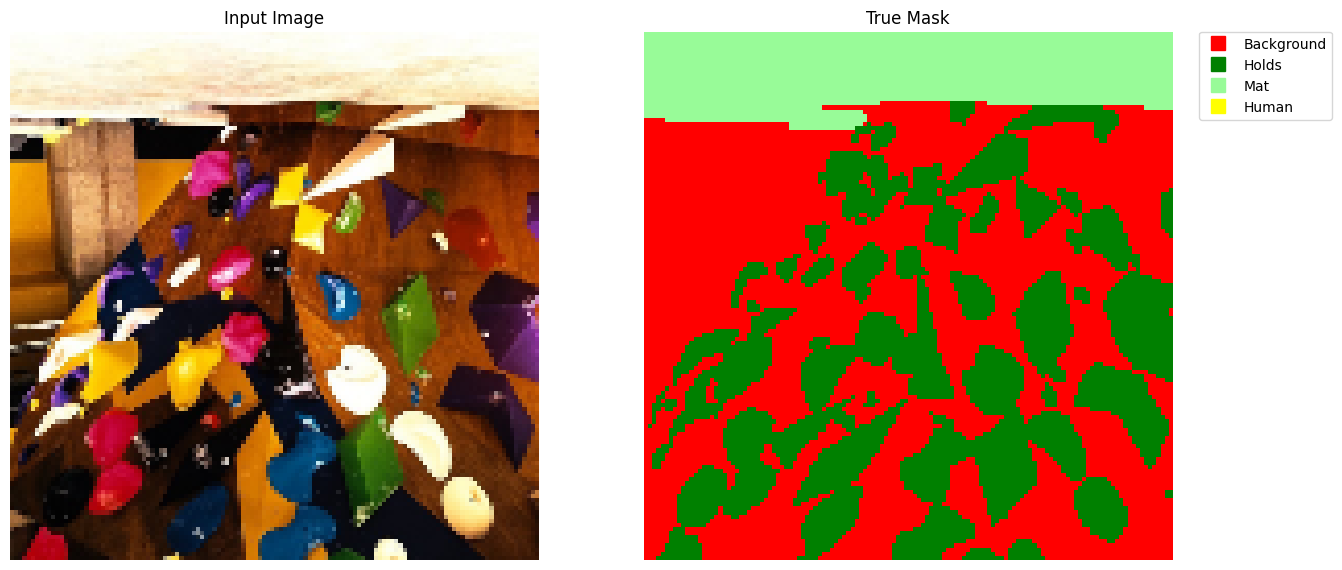

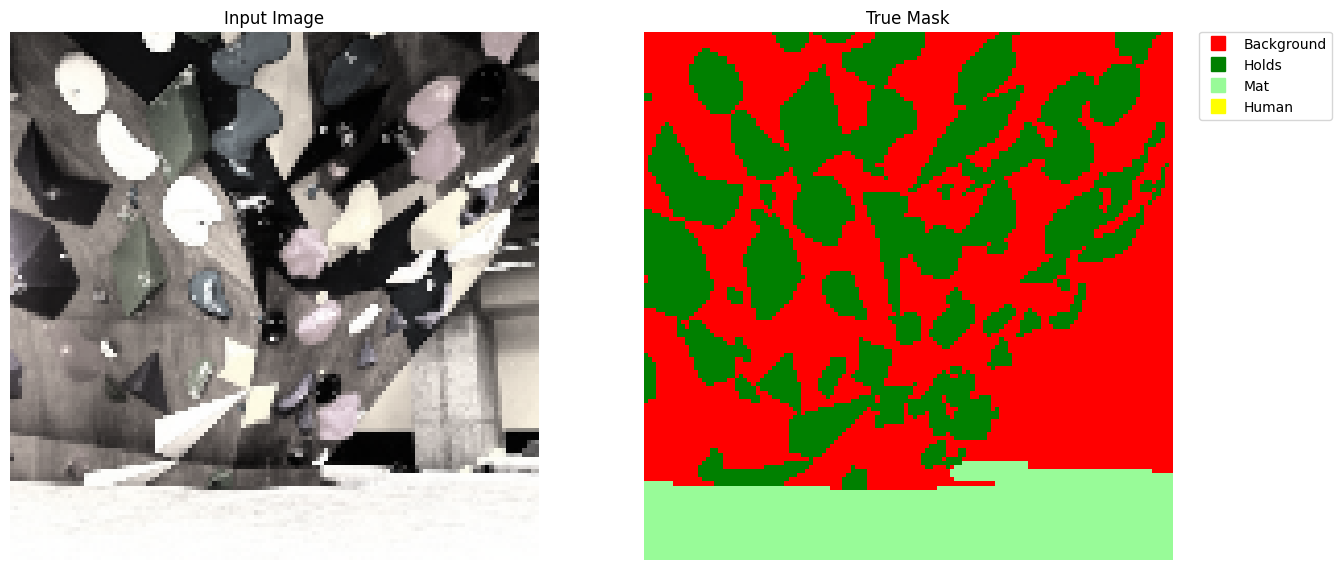

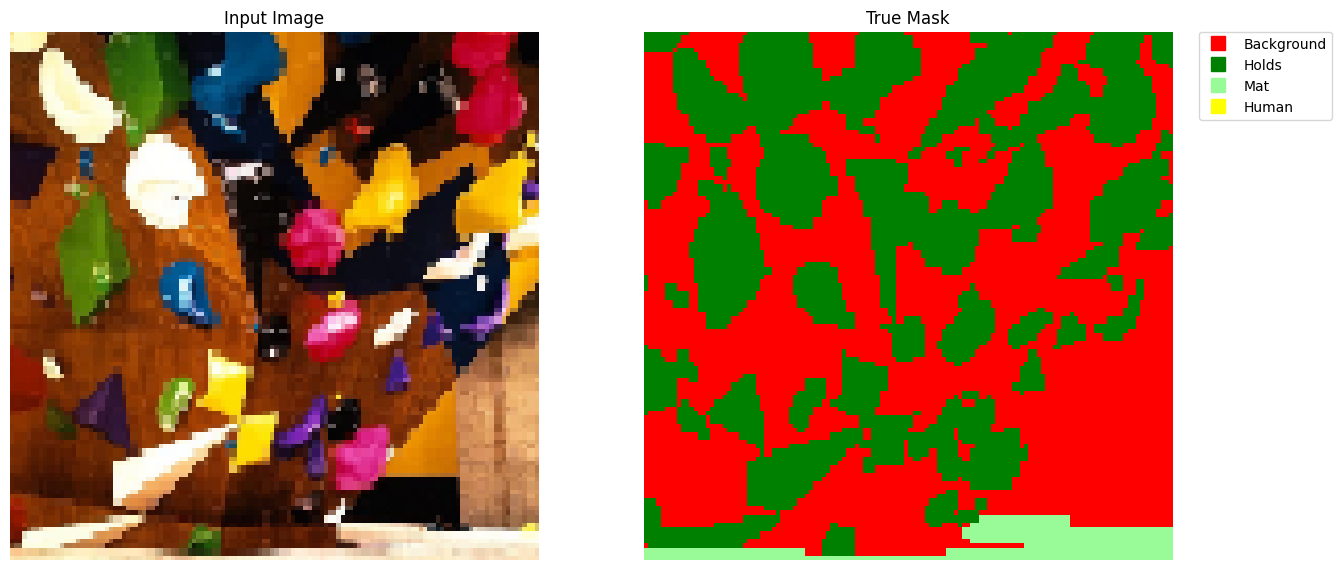

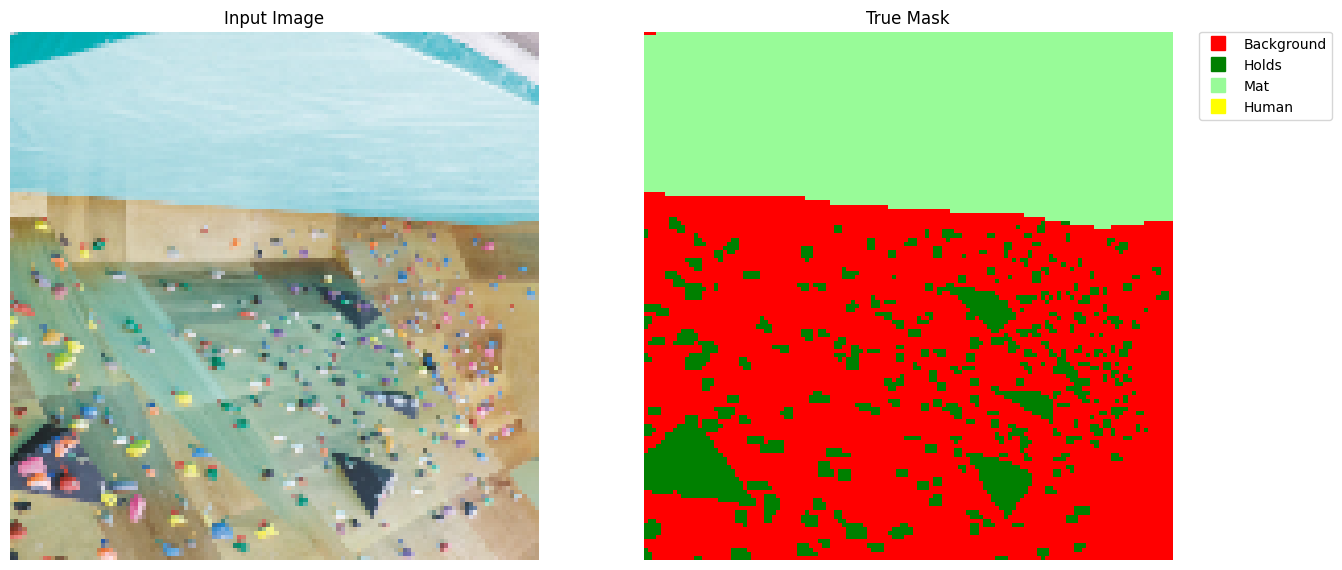

2024-01-13 16:47:36.725071: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


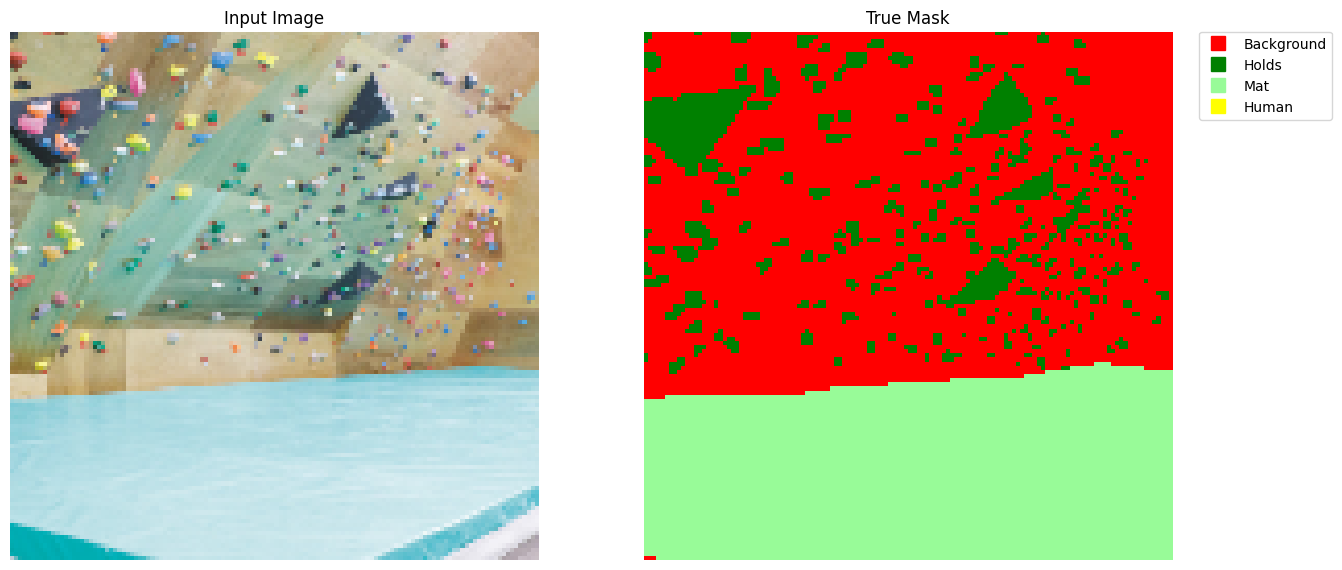

In [15]:
for images, masks in train_batches.take(5):
    sample_image, sample_mask = images[0], masks[0]

    display([sample_image, sample_mask])

In [16]:
import keras
from keras import Model


class UNet(Model):
    def __init__(self, class_num):
        super().__init__()
        # Network
        self.enc = Encoder(class_num)
        self.dec = Decoder(class_num)

    def call(self, x, **kwargs):
        z1, z2, z3, z4_dropout, z5_dropout = self.enc(x)
        y = self.dec(z1, z2, z3, z4_dropout, z5_dropout)

        return y


class Encoder(Model):
    def __init__(self, class_num):
        super().__init__()
        # Network
        self.block1_conv1 = tf.keras.layers.Conv2D(64, (3, 3),
                                                   name='block1_conv1',
                                                   activation='relu',
                                                   padding='same',
                                                   input_shape=(IMAGE_WIDTH,
                                                                IMAGE_HEIGHT,
                                                                3))
        self.block1_conv2 = tf.keras.layers.Conv2D(64, (3, 3),
                                                   name='block1_conv2',
                                                   padding='same')
        self.block1_bn = tf.keras.layers.BatchNormalization()
        self.block1_act = tf.keras.layers.ReLU()
        self.block1_pool = tf.keras.layers.MaxPooling2D((2, 2), strides=None,
                                                        name='block1_pool')

        self.block2_conv1 = tf.keras.layers.Conv2D(128, (3, 3),
                                                   name='block2_conv1',
                                                   activation='relu',
                                                   padding='same')
        self.block2_conv2 = tf.keras.layers.Conv2D(128, (3, 3),
                                                   name='block2_conv2',
                                                   padding='same')
        self.block2_bn = tf.keras.layers.BatchNormalization()
        self.block2_act = tf.keras.layers.ReLU()
        self.block2_pool = tf.keras.layers.MaxPooling2D((2, 2), strides=None,
                                                        name='block2_pool')

        self.block3_conv1 = tf.keras.layers.Conv2D(256, (3, 3),
                                                   name='block3_conv1',
                                                   activation='relu',
                                                   padding='same')
        self.block3_conv2 = tf.keras.layers.Conv2D(256, (3, 3),
                                                   name='block3_conv2',
                                                   padding='same')
        self.block3_bn = tf.keras.layers.BatchNormalization()
        self.block3_act = tf.keras.layers.ReLU()
        self.block3_pool = tf.keras.layers.MaxPooling2D((2, 2), strides=None,
                                                        name='block3_pool')

        self.block4_conv1 = tf.keras.layers.Conv2D(512, (3, 3),
                                                   name='block4_conv1',
                                                   activation='relu',
                                                   padding='same')
        self.block4_conv2 = tf.keras.layers.Conv2D(512, (3, 3),
                                                   name='block4_conv2',
                                                   padding='same')
        self.block4_bn = tf.keras.layers.BatchNormalization()
        self.block4_act = tf.keras.layers.ReLU()
        self.block4_dropout = tf.keras.layers.Dropout(0.5)
        self.block4_pool = tf.keras.layers.MaxPooling2D((2, 2), strides=None,
                                                        name='block4_pool')

        self.block5_conv1 = tf.keras.layers.Conv2D(1024, (3, 3),
                                                   name='block5_conv1',
                                                   activation='relu',
                                                   padding='same')
        self.block5_conv2 = tf.keras.layers.Conv2D(1024, (3, 3),
                                                   name='block5_conv2',
                                                   padding='same')
        self.block5_bn = tf.keras.layers.BatchNormalization()
        self.block5_act = tf.keras.layers.ReLU()
        self.block5_dropout = tf.keras.layers.Dropout(0.5)

    def call(self, x, training=False):
        z1 = self.block1_conv1(x)
        z1 = self.block1_conv2(z1)
        z1 = self.block1_bn(z1)
        z1 = self.block1_act(z1)
        z1_pool = self.block1_pool(z1)

        z2 = self.block2_conv1(z1_pool)
        z2 = self.block2_conv2(z2)
        z2 = self.block2_bn(z2)
        z2 = self.block2_act(z2)
        z2_pool = self.block2_pool(z2)

        z3 = self.block3_conv1(z2_pool)
        z3 = self.block3_conv2(z3)
        z3 = self.block3_bn(z3)
        z3 = self.block3_act(z3)
        z3_pool = self.block3_pool(z3)

        z4 = self.block4_conv1(z3_pool)
        z4 = self.block4_conv2(z4)
        z4 = self.block4_bn(z4)
        z4 = self.block4_act(z4)
        z4_dropout = self.block4_dropout(z4)
        z4_pool = self.block4_pool(z4_dropout)

        z5 = self.block5_conv1(z4_pool)
        z5 = self.block5_conv2(z5)
        z5 = self.block5_bn(z5)
        z5 = self.block5_act(z5)
        z5_dropout = self.block5_dropout(z5)

        return z1, z2, z3, z4_dropout, z5_dropout


class Decoder(Model):
    def __init__(self, class_num):
        super().__init__()
        # Network
        self.block6_up = tf.keras.layers.UpSampling2D(size=(2, 2))
        self.block6_conv1 = tf.keras.layers.Conv2D(512, (2, 2),
                                                   name='block6_conv1',
                                                   activation='relu',
                                                   padding='same')
        self.block6_conv2 = tf.keras.layers.Conv2D(512, (3, 3),
                                                   name='block6_conv2',
                                                   activation='relu',
                                                   padding='same')
        self.block6_conv3 = tf.keras.layers.Conv2D(512, (3, 3),
                                                   name='block6_conv3',
                                                   padding='same')
        self.block6_bn = tf.keras.layers.BatchNormalization()
        self.block6_act = tf.keras.layers.ReLU()

        self.block7_up = tf.keras.layers.UpSampling2D(size=(2, 2))
        self.block7_conv1 = tf.keras.layers.Conv2D(256, (2, 2),
                                                   name='block7_conv1',
                                                   activation='relu',
                                                   padding='same')
        self.block7_conv2 = tf.keras.layers.Conv2D(256, (3, 3),
                                                   name='block7_conv2',
                                                   activation='relu',
                                                   padding='same')
        self.block7_conv3 = tf.keras.layers.Conv2D(256, (3, 3),
                                                   name='block7_conv3',
                                                   padding='same')
        self.block7_bn = tf.keras.layers.BatchNormalization()
        self.block7_act = tf.keras.layers.ReLU()

        self.block8_up = tf.keras.layers.UpSampling2D(size=(2, 2))
        self.block8_conv1 = tf.keras.layers.Conv2D(128, (2, 2),
                                                   name='block8_conv1',
                                                   activation='relu',
                                                   padding='same')
        self.block8_conv2 = tf.keras.layers.Conv2D(128, (3, 3),
                                                   name='block8_conv2',
                                                   activation='relu',
                                                   padding='same')
        self.block8_conv3 = tf.keras.layers.Conv2D(128, (3, 3),
                                                   name='block8_conv3',
                                                   padding='same')
        self.block8_bn = tf.keras.layers.BatchNormalization()
        self.block8_act = tf.keras.layers.ReLU()

        self.block9_up = tf.keras.layers.UpSampling2D(size=(2, 2))
        self.block9_conv1 = tf.keras.layers.Conv2D(64, (2, 2),
                                                   name='block9_conv1',
                                                   activation='relu',
                                                   padding='same')
        self.block9_conv2 = tf.keras.layers.Conv2D(64, (3, 3),
                                                   name='block9_conv2',
                                                   activation='relu',
                                                   padding='same')
        self.block9_conv3 = tf.keras.layers.Conv2D(64, (3, 3),
                                                   name='block9_conv3',
                                                   padding='same')
        self.block9_bn = tf.keras.layers.BatchNormalization()
        self.block9_act = tf.keras.layers.ReLU()
        self.output_conv = tf.keras.layers.Conv2D(class_num,
                                                  (1, 1), name='output_conv',
                                                  activation='sigmoid')

    def call(self, z1, z2, z3, z4_dropout, z5_dropout):
        z6_up = self.block6_up(z5_dropout)
        z6 = self.block6_conv1(z6_up)
        z6 = tf.keras.layers.concatenate([z4_dropout, z6], axis=3)
        z6 = self.block6_conv2(z6)
        z6 = self.block6_conv3(z6)
        z6 = self.block6_bn(z6)
        z6 = self.block6_act(z6)

        z7_up = self.block7_up(z6)
        z7 = self.block7_conv1(z7_up)
        z7 = tf.keras.layers.concatenate([z3, z7], axis=3)
        z7 = self.block7_conv2(z7)
        z7 = self.block7_conv3(z7)
        z7 = self.block7_bn(z7)
        z7 = self.block7_act(z7)

        z8_up = self.block8_up(z7)
        z8 = self.block8_conv1(z8_up)
        z8 = tf.keras.layers.concatenate([z2, z8], axis=3)
        z8 = self.block8_conv2(z8)
        z8 = self.block8_conv3(z8)
        z8 = self.block8_bn(z8)
        z8 = self.block8_act(z8)

        z9_up = self.block9_up(z8)
        z9 = self.block9_conv1(z9_up)
        z9 = tf.keras.layers.concatenate([z1, z9], axis=3)
        z9 = self.block9_conv2(z9)
        z9 = self.block9_conv3(z9)
        z9 = self.block9_bn(z9)
        z9 = self.block9_act(z9)
        y = self.output_conv(z9)
        y = Activation('softmax')(y)

        return y


In [17]:
# PSP net
def Pyramid_Pooling_Module(features, f=64, p1=2, p2=3, p3=6):
    shape = features.shape
    red = GlobalAveragePooling2D()(features)
    red = Reshape((1, 1, shape[-1]))(red)
    red = Conv2D(filters=f, kernel_size=(1, 1), padding='same', use_bias=False)(
        red)
    red = BatchNormalization()(red)
    red = Activation('relu')(red)
    red = UpSampling2D(size=shape[1], interpolation='bilinear')(red)

    orange = AveragePooling2D(pool_size=(p1))(features)
    orange = Conv2D(filters=f, kernel_size=(1, 1), padding='same',
                    use_bias=False)(orange)
    orange = BatchNormalization()(orange)
    orange = Activation('relu')(orange)
    orange = UpSampling2D(size=p1, interpolation='bilinear')(orange)

    blue = AveragePooling2D(pool_size=(p2))(features)
    blue = Conv2D(filters=f, kernel_size=(1, 1), padding='same',
                  use_bias=False)(blue)
    blue = BatchNormalization()(blue)
    blue = Activation('relu')(blue)
    blue = UpSampling2D(size=p2, interpolation='bilinear')(blue)

    green = AveragePooling2D(pool_size=(p3))(features)
    green = Conv2D(filters=f, kernel_size=(1, 1), padding='same',
                   use_bias=False)(green)
    green = BatchNormalization()(green)
    green = Activation('relu')(green)
    green = UpSampling2D(size=p3, interpolation='bilinear')(green)

    return Concatenate()([features, red, orange, blue, green])


def PSPNet(inputs, classes=100):
    inputs = Input(inputs)

    base_model = ResNet50(weights='imagenet', include_top=False,
                          input_tensor=inputs)
    base_model_features = base_model.get_layer('conv3_block4_add').output

    x = Pyramid_Pooling_Module(base_model_features, f=64, p1=2, p2=4, p3=8)
    x = UpSampling2D(size=8, interpolation='bilinear')(x)

    x = Conv2D(filters=64, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    """ Outputs """
    x = Conv2D(classes, (1, 1), name='output_layer')(x)

    if classes == 1:
        x = Activation('sigmoid')(x)
    else:
        x = Activation('softmax')(x)

    model = Model(inputs=inputs, outputs=x)

    return model

In [18]:
# deep lab v3

def ASPP(image_features):
    shape = image_features.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]))(image_features)
    y_pool = Conv2D(filters=32, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=32, kernel_size=1, padding='same', use_bias=False)(image_features)
    y_1 = BatchNormalization(name=f'bn_2')(y_1)
    y_1 = Activation('relu', name=f'relu_2')(y_1)

    y_6 = Conv2D(filters=32, kernel_size=3, padding='same', dilation_rate=2, use_bias=False)(
        image_features)
    y_6 = BatchNormalization(name=f'bn_3')(y_6)
    y_6 = Activation('relu', name=f'relu_3')(y_6)

    y_12 = Conv2D(filters=32, kernel_size=1, padding='same', dilation_rate=4, use_bias=False)(
        image_features)
    y_12 = BatchNormalization(name=f'bn_4')(y_12)
    y_12 = Activation('relu', name=f'relu_4')(y_12)

    y_18 = Conv2D(filters=32, kernel_size=3, padding='same', dilation_rate=6, use_bias=False)(
        image_features)
    y_18 = BatchNormalization(name=f'bn_5')(y_18)
    y_18 = Activation('relu', name=f'relu_5')(y_18)

    y_c = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=32, kernel_size=1, padding='same', use_bias=False)(y_c)
    y = BatchNormalization(name=f'bn_6')(y)
    y = Activation('relu', name=f'relu_6')(y)

    return y


def DeepLabV3Plus(inputs, classes=1):
    inputs = Input(inputs)

    ResNext101, preprocess_input = Classifiers.get('resnext101')
    base_model = ResNext101(input_tensor=inputs, weights='imagenet', classes=1, include_top=False)
    high_level_image_features = base_model.get_layer('stage4_unit1_relu1').output

    x_a = ASPP(high_level_image_features)
    x_a = UpSampling2D(size=4, interpolation='bilinear')(x_a)

    low_level_image_features = base_model.get_layer('stage2_unit1_relu1').output

    x_b = Conv2D(filters=32, kernel_size=1, padding='same', use_bias=False)(
        low_level_image_features)
    x_b = BatchNormalization(name=f'bn_7')(x_b)
    x_b = Activation('relu', name=f'relu_7')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=32, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_8')(x)
    x = Activation('relu', name=f'relu_8')(x)

    x = Conv2D(filters=32, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization(name=f'bn_9')(x)
    x = Activation('relu', name=f'relu_9')(x)

    x = UpSampling2D(size=4, interpolation='bilinear')(x)

    """ Outputs """
    x = Conv2D(classes, (1, 1), name='output_layer')(x)

    if classes == 1:
        x = Activation('sigmoid')(x)
    else:
        x = Activation('softmax')(x)

    model = Model(inputs=inputs, outputs=x)

    return model


In [19]:
CLASS_NAME = ['Background',
              'Holds',
              'Mat',
              'Human',
              ]


class CustomMeanIoU(tf.keras.metrics.Metric):
    def __init__(self, name='custom_mean_iou', num_classes=OUTPUT_CLASSES, c_name=None, dtype=None):
        super(CustomMeanIoU, self).__init__(name=name, dtype=dtype)
        self.num_classes = num_classes
        self.true_positives = [
            self.add_weight('true_positive_{}'.format(i), initializer='zeros')
            for i in range(self.num_classes)]
        self.false_positives = [
            self.add_weight('false_positive_{}'.format(i), initializer='zeros')
            for i in range(self.num_classes)]
        self.false_negatives = [
            self.add_weight('false_negative_{}'.format(i), initializer='zeros')
            for i in range(self.num_classes)]

        if c_name is not None:
            self.c_name = c_name
        else:
            self.c_name = [str(i) for i in range(self.num_classes)]

        self.iot_dict = {}
        for i in range(self.num_classes):
            self.iot_dict[self.c_name[i]] = 0

    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        バッチごとにIoUを計算
        :param y_true: 
        :param y_pred: 
        :param sample_weight: 
        :return: 
        """

        # スパース形式からone-hot形式に変換
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), self.num_classes)

        # 不要な行を削除
        y_true = tf.cast(tf.squeeze(y_true, axis=3), tf.int32)

        # 最大値を持つインデックスを取得
        y_pred = tf.argmax(y_pred, axis=-1)
        y_pred = tf.one_hot(tf.cast(y_pred, tf.int32), self.num_classes)

        # 各クラスごとにTrue Positive, False Positive, False Negativeを計算
        for i in range(self.num_classes):
            y_true_i = tf.cast(tf.equal(y_true, i), tf.int32)
            y_pred_i = tf.cast(tf.equal(y_pred, i), tf.int32)

            # int32型のテンソルをfloat32型にキャスト
            true_positives_update = tf.cast(tf.reduce_sum(y_true_i * y_pred_i),
                                            tf.float32)
            false_positives_update = tf.cast(
                tf.reduce_sum((1 - y_true_i) * y_pred_i), tf.float32)
            false_negatives_update = tf.cast(
                tf.reduce_sum(y_true_i * (1 - y_pred_i)), tf.float32)

            self.true_positives[i].assign_add(true_positives_update)
            self.false_positives[i].assign_add(false_positives_update)
            self.false_negatives[i].assign_add(false_negatives_update)

    def result(self):
        """
        各クラスごとにIoUを計算
        :return: 
        """
        # 各クラスごとにIoUを計算
        for i in range(self.num_classes):
            iou = self.true_positives[i] / (
                    self.true_positives[i] + self.false_positives[i] +
                    self.false_negatives[i] + tf.keras.backend.epsilon())
            self.iot_dict[self.c_name[i]] = iou
        return self.iot_dict

    def reset_state(self):
        """
        エポック終わりにすべての結果をリセットする
        :return: 
        """
        for i in range(self.num_classes):
            self.true_positives[i].assign(0)
            self.false_positives[i].assign(0)
            self.false_negatives[i].assign(0)

        # iot_dict を初期化
        for i in range(self.num_classes):
            self.iot_dict[self.c_name[i]] = 0

    def get_config(self):
        config = super(CustomMeanIoU, self).get_config()
        config.update({
            'num_classes': self.num_classes,
            'c_name': self.c_name
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [20]:
# model = unet_model(output_channels=OUTPUT_CLASSES)

# PSP net
# model = PSPNet((IMAGE_WIDTH, IMAGE_HEIGHT, 3), classes=OUTPUT_CLASSES)

# U-net
# model = UNet(OUTPUT_CLASSES)

# deeplab
model = DeepLabV3Plus((IMAGE_WIDTH, IMAGE_HEIGHT, 3), classes=OUTPUT_CLASSES)

iou = CustomMeanIoU(name="iou", c_name=CLASS_NAME)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=False),
              metrics=['accuracy', iou]
              )


トレーニングする前に、モデルが何を予測するかを試してみましょう。

In [21]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [22]:
def show_predictions(batch=val_batches, num=1, predict_model=model):
    count = 0
    for images, masks in batch.take(1):
        for image, mask in zip(images, masks):
            sample_image, sample_mask = image, mask
            pred_input = tf.expand_dims(sample_image, axis=0)
            pred_mask = predict_model.predict(pred_input)

            display([sample_image, sample_mask, create_mask(pred_mask)])

            count += 1
            if count == num:
                break


2024-01-13 16:47:49.860392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 18s 18s/step


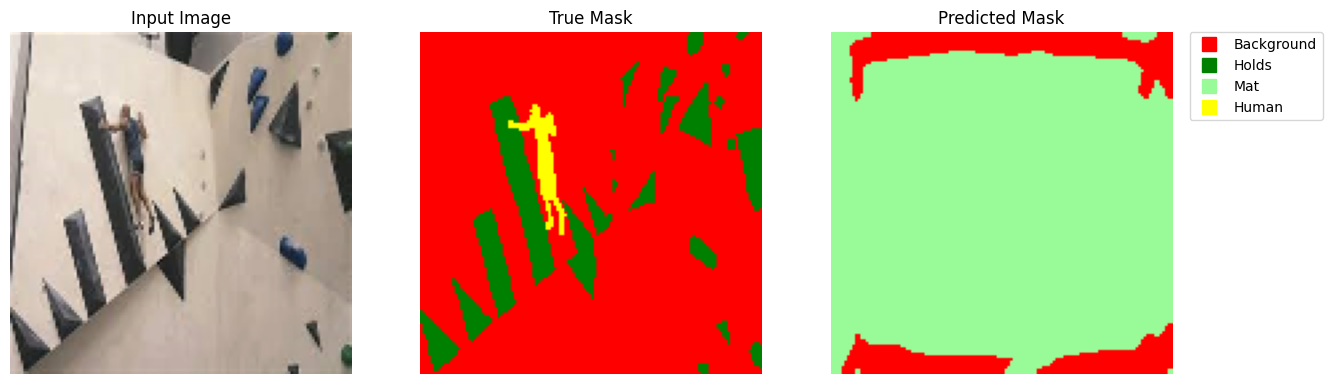

1/1 [==============================] - 0s 400ms/step


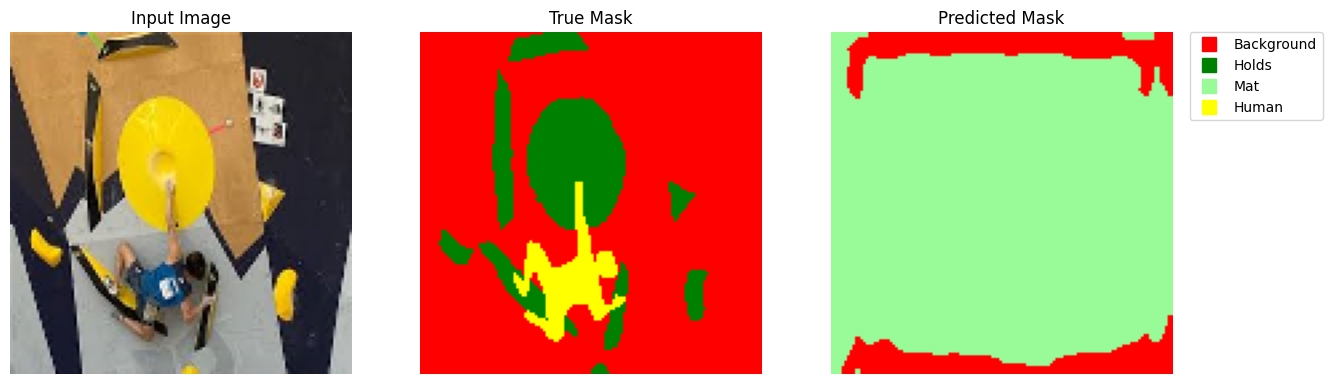

1/1 [==============================] - 0s 352ms/step


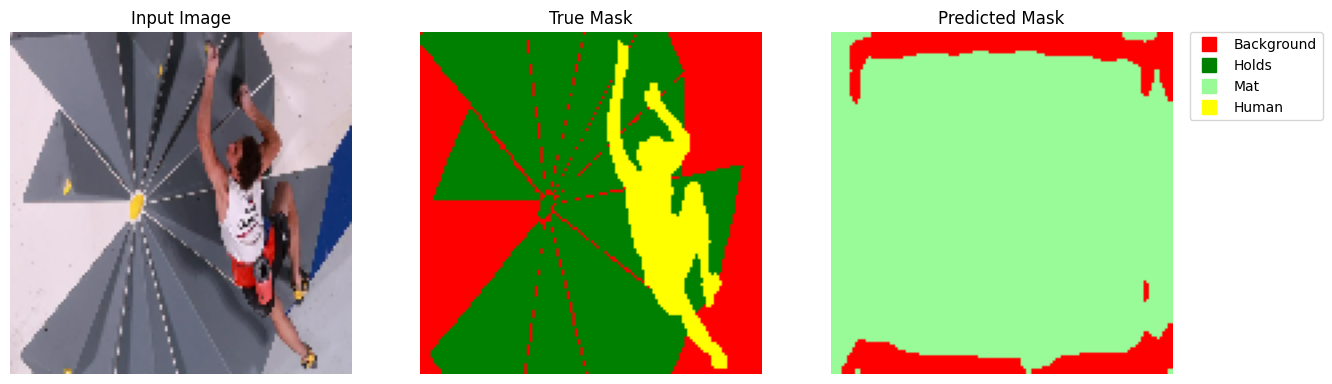

In [23]:
show_predictions(num=3)

以下に定義されるコールバックは、トレーニング中にモデルがどのように改善するかを観測するために使用されます。

In [24]:
class CustomModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):
    """
    Custom Metricsが特定の閾値を超えたときだけモデルを保存するチェックポイント
    thresholdsはkeyがmetrics名、値が閾値となるDictionary
    """

    def __init__(self, filepath, thresholds, mode='auto', inverse=False):
        super(CustomModelCheckpoint, self).__init__(filepath)

        self.filepath = filepath
        self.thresholds = thresholds
        self.inverse = inverse
        self.max_log = {}

        for k, v in self.thresholds.items():
            self.max_log[k] = 0

    def on_epoch_end(self, epoch, logs=None):
        """
        logsにmetricsに指定した内容が（validationの方はval_というプレフィックス付きで）入っている。
        """
        logs = logs or {}
        filepath = self.filepath.format(epoch=epoch, **logs)

        save = True
        for k, v in self.thresholds.items():
            if self.inverse:
                if (k in logs and logs[k] > v) or np.isnan(logs[k]):
                    save = False
                    break
            else:
                if (k in logs and logs[k] < v) or (
                        logs[k] <= self.max_log[k]) or np.isnan(logs[k]):
                    print("not saved {} : {}".format(k, logs[k]))
                    save = False
                    break

        if save:
            print("Save Model")
            self.model.save(filepath, overwrite=True)

            # 新しいモデルが保存された時の結果を保存しておく
            for k, v in self.thresholds.items():
                self.max_log[k] = logs[k]

        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch + 1))

        for k in self.params.keys():
            print(f"{k}: {self.params[k]}")


# 実行しているディレクトリないに checkpoint ディレクトリを作成
checkpoint_filepath = './checkpoint'

In [25]:
EPOCHS = 500
VAL_SUBSPLITS = 1
VALIDATION_STEPS = max(len(val_images) // BATCH_SIZE // VAL_SUBSPLITS, 1)
print(f"VALIDATION_STEPS: {VALIDATION_STEPS}")
print(f"BATCH_SIZE: {BATCH_SIZE}")

VALIDATION_STEPS: 1
BATCH_SIZE: 5


1/1 [==============================] - 0s 298ms/step


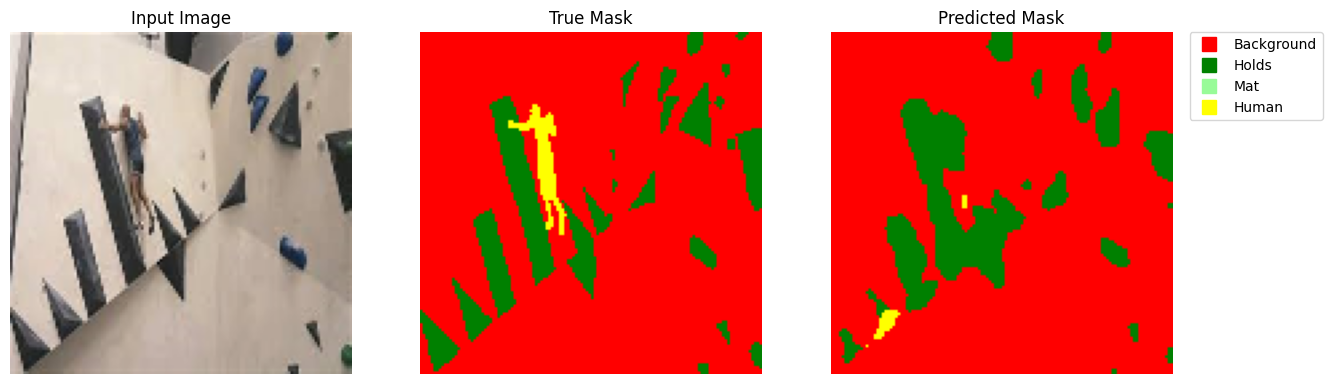


Sample Prediction after epoch 83

verbose: 1
epochs: 500
steps: 291
291/291 [==============================] - 176s 605ms/step - loss: 0.2421 - accuracy: 0.9007 - Background: 0.9257 - Holds: 0.7926 - Mat: 0.0000e+00 - Human: 0.0000e+00 - val_loss: 1.9824 - val_accuracy: 0.6748 - val_Background: 0.8044 - val_Holds: 0.5093 - val_Mat: 0.0000e+00 - val_Human: 0.0000e+00
Epoch 84/500
288/291 [============================>.] - ETA: 1s - loss: 0.2411 - accuracy: 0.9011 - Background: 0.9251 - Holds: 0.7913 - Mat: 0.0000e+00 - Human: 0.0000e+00

In [ ]:
model_history = model.fit(train_batches,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[CustomModelCheckpoint(
                              checkpoint_filepath,
                              thresholds={
                                  'accuracy': 0.9,
                                  'val_accuracy': 0.75,
                                  'Holds': 0.6,
                                  'val_Holds': 0.5
                              }
                          )
                          ]
                          )

In [1]:
for key in model_history.history.keys():
    print(f"key: {key}")

NameError: name 'model_history' is not defined

In [ ]:
# CLASS_NAME に含まれる値をプロットする
plt.figure()

for key in model_history.history.keys():
    if key in CLASS_NAME:
        # プロットの色や形を変更する
        plt.plot(model_history.history[key], 'r', label=key)
        plt.plot(model_history.history['val_' + key], 'bo', label='val_' + key)
        plt.title(key)
        plt.xlabel('Epoch')
        plt.ylabel(key)
        plt.ylim([0, 1])
        plt.legend()
plt.show()

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

x_window = min(EPOCHS - 10, len(loss))
start = EPOCHS - x_window

x_size = min(x_window, len(loss))

loss = loss[-x_size:]
val_loss = val_loss[-x_size:]
x = range(start, start + x_size)

plt.figure()
plt.plot(x, loss, 'r', label='Training loss')
plt.plot(x, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

x_window = min(EPOCHS - 10, len(acc))
start = EPOCHS - x_window

x_size = min(x_window, len(acc))

acc = acc[-x_size:]
val_acc = val_acc[-x_size:]
x = range(start, start + x_size)

plt.figure()
plt.plot(x, acc, 'r', label='Training accuracy')
plt.plot(x, val_acc, 'bo', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Value')
# plt.ylim([0.6, 1])
plt.legend()
plt.show()

## 予測する

いくつか予測を行ってみましょう。時間の節約重視の場合はエポック数を少なくしますが、高精度の結果重視の場合はエポック数を増やして設定します。

In [ ]:
checkpoint_filepath = "./checkpoint"

# カスタムオブジェクトの辞書を作成
custom_objects = {"CustomMeanIoU": CustomMeanIoU(name="iou", c_name=CLASS_NAME)}

# 精度が良かったモデルを読み込む
checkpoint_model = tf.keras.models.load_model(checkpoint_filepath, custom_objects=custom_objects)

In [ ]:
show_predictions(train_batches, 2, checkpoint_model)

In [ ]:
show_predictions(val_batches, 4, checkpoint_model)

In [ ]:
# test データの結果を出力
show_predictions(test_batches, 2, checkpoint_model)

In [ ]:
# test データを使用して評価
result = checkpoint_model.evaluate(test_batches)

 ## オプション: 不均衡なクラスとクラスの重み

つまり、このチュートリアルのサンプル重みを作るには、`(data, label)` ペアを取って `(data, label, sample_weight)` トリプルを返す関数が必要となります。`sample_weight` は各ピクセルのクラス重みを含む 1-channel の画像です。

実装を可能な限り単純にするために、ラベルを`class_weight` リストのインデックスとして使用します。

In [ ]:
def add_sample_weights(image, label):
    # The weights for each class, with the constraint that:
    #     sum(class_weights) == 1.0
    class_weights = tf.constant([0.5, 2.0, 2.0, 1.5])
    class_weights = class_weights / tf.reduce_sum(class_weights)

    # Create an image of `sample_weights` by using the label at each pixel as an
    # index into the `class weights` .
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

    return image, label, sample_weights

この結果、データセットの各要素には、3 つの画像が含まれます。

In [ ]:
train_batches.map(add_sample_weights).element_spec

これで、この重み付けが付けられたデータセットでモデルをトレーニングできるようになりました。

In [ ]:
weighted_model = DeepLabV3Plus(OUTPUT_CLASSES)
weighted_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(
                           from_logits=False),
                       metrics=['accuracy', iou]
                       )
weighted_model.summary()

In [ ]:
EPOCHS = 100
checkpoint_filepath = './checkpoint_weighted'
weighted_model_history = model.fit(train_batches,
                                   epochs=EPOCHS,
                                   steps_per_epoch=STEPS_PER_EPOCH,
                                   validation_steps=VALIDATION_STEPS,
                                   validation_data=val_batches,
                                   callbacks=[CustomModelCheckpoint(
                                       checkpoint_filepath,
                                       thresholds={
                                           'accuracy': 0.8,
                                           'val_accuracy': 0.7,
                                           'Holds': 0.6,
                                           'val_Holds': 0.5
                                       }
                                   )
                                   ]
                                   )

In [ ]:
loss = weighted_model_history.history['loss']
val_loss = weighted_model_history.history['val_loss']

plt.figure()
plt.plot(weighted_model_history.epoch, loss, 'r', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
loss = weighted_model_history.history['loss']
val_loss = weighted_model_history.history['val_loss']

x = range(len(loss))
plt.figure()
plt.plot(x, loss, 'r', label='Training loss')
plt.plot(x, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
# plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
show_predictions(test_batches, 3, weighted_model)



## 次のステップ

これで画像セグメンテーションとは何か、それがどのように機能するかについての知識が得られたはずです。このチュートリアルは、異なる中間レイヤー出力や、異なる事前トレーニング済みモデルでも試すことができます。また、Kaggle がホストしている [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) 画像マスキングチャレンジに挑戦してみることもお勧めです。

[Tensorflow Object Detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/README.md) を参照して、独自のデータで再トレーニング可能な別のモデルを確認するのも良いでしょう。トレーニング済みのモデルは、[TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/tf2_object_detection#optional) にあります。